In [171]:
import pandas as pd
import numpy as np
from pandas import json_normalize
import json
import requests

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import itertools

import torch
from torch import nn  
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from kmodes.kprototypes import KPrototypes
from sklearn.impute import SimpleImputer
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer

from scipy.stats import shapiro

from bertopic import BERTopic

plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

In [2]:
url = 'https://www.bibliotechediroma.it/sebina/repository/opendata/COMMENTI_UTE/202209/COMMENTI_UTE_01.json'

r = requests.get(url)

df = json_normalize(r.json(), record_path =['tabella'])

df.head(3)

Punteggio utente sul titolo Id. commento Punteggio medio titolo  \
0                           4          138                 4.0000   
1                        None         3567                   None   
2                        None         3653                   None   

  Cod. tipo materiale            Tipo documento Identificativo titolo  \
0                   M  Testo a stampa (moderno)                    91   
1                   M  Testo a stampa (moderno)                   208   
2                   M  Testo a stampa (moderno)                   429   

  Eta' utente Tipo utente Anno di pubblicazione    CAP Tipo materiale  \
0          31    STUDENTE                  1990  00148  Libro moderno   
1          33    STUDENTE                  1982  04011  Libro moderno   
2          33    STUDENTE                  1990  04011  Libro moderno   

  Lingua 3 Lingua 2      Natura  \
0                    Monografia   
1                    Monografia   
2                    Monografia   

                                Descrizione commento  Lingua 1  \
0  Libro consigliato a tutti coloro che vogliono ...  ITALIANO   
1  Un volumetto davvero prezioso che raccoglie ep...  ITALIANO   
2  Terzo volumetto di Pizzi. I versi si rincorron...  ITALIANO   

  Cod. tipo utente Cod. Lingua 1 Cod. natura Cod. Lingua 3 Cod. Lingua 2  \
0                S           ITA           M                               
1                S           ITA           M                               
2                S           ITA           M                               

  Cod. tipo documento                                             Titolo  \
0                  LM  Il *porto sepolto / Giuseppe Ungaretti ; a cur...   
1                  LM  *Carte segrete / Scipione ; prefazione di Amel...   
2                  LM  *Acquerugiole / Marina Pizzi. - Milano : Croce...   

                                     Titolo commento Data commento  
0  Interpretazione ed analisi scritta benissimo, ...    2011/02/23  
1                              Testi rari e preziosi    2018/08/28  
2                   "Genuflesse finanche le parole"     2018/08/31

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18905 entries, 0 to 18904
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Punteggio utente sul titolo  813 non-null    object
 1   Id. commento                 18905 non-null  object
 2   Punteggio medio titolo       1216 non-null   object
 3   Cod. tipo materiale          18905 non-null  object
 4   Tipo documento               18905 non-null  object
 5   Identificativo titolo        18905 non-null  object
 6   Eta' utente                  18822 non-null  object
 7   Tipo utente                  18905 non-null  object
 8   Anno di pubblicazione        18819 non-null  object
 9   CAP                          18905 non-null  object
 10  Tipo materiale               18902 non-null  object
 11  Lingua 3                     18905 non-null  object
 12  Lingua 2                     18905 non-null  object
 13  Natura                       18

In [4]:
# Notably, a column from the dataset collects a score given by the user to the product, from 1 to 5. Nevertheless, out of the 15636 total reviews, only 5.2% display this score, therefore this information will not be used:

no_scores = df['Punteggio utente sul titolo'].isna().sum()

print("Total reviews: ", df.shape[0])
print("No scores given: ", no_scores)
print("Perc. of given scores: ", str(round((1-no_scores/df.shape[0])*100,2))+'%' )

Total reviews:  18905
No scores given:  18092
Perc. of given scores:  4.3%


In [6]:
df['Tipo materiale'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'

Tipo materiale
Libro moderno          79.94%
Audiovisivo             11.6%
Risorsa elettronica     8.44%
Musica                  0.01%
Name: proportion, dtype: object

Null ages:  0


count    18905.000000
mean        49.850198
std         15.831696
min          0.000000
25%         39.000000
50%         51.000000
75%         63.000000
max         94.000000
Name: Eta' utente, dtype: float64

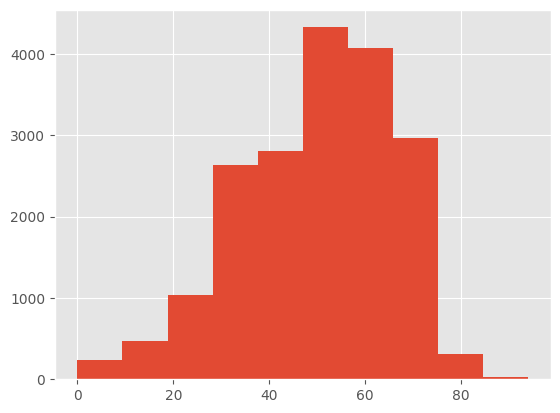

In [7]:
df["Eta' utente"] = df["Eta' utente"].fillna(0).astype(int)

df["Eta' utente"].hist()
print("Null ages: ", df["Eta' utente"].isna().sum())
df["Eta' utente"].describe()

In [8]:
df['Tipo utente'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'

Tipo utente
IMPIEGATO                         32.02%
STUDENTE                          19.29%
IMPRENDITORE E LIBERO PROFESS.    12.75%
RITIRATO DAL LAVORO               10.92%
ALTRI LAVORATORI DIPENDENTI        5.73%
NON OCCUPATO                       5.71%
CASALINGA                          5.19%
LAVORATORE AUTONOMO E COADIUV.     3.39%
DIRIGENTE                          2.97%
ALTRE CATEGORIE NON PROFESSION     0.78%
INSEGNANTE                         0.52%
BIBLIOTECA SOL                     0.43%
OPERAIO                            0.28%
BIBLIOTECARIO SOL                  0.01%
Name: proportion, dtype: object

<Axes: >

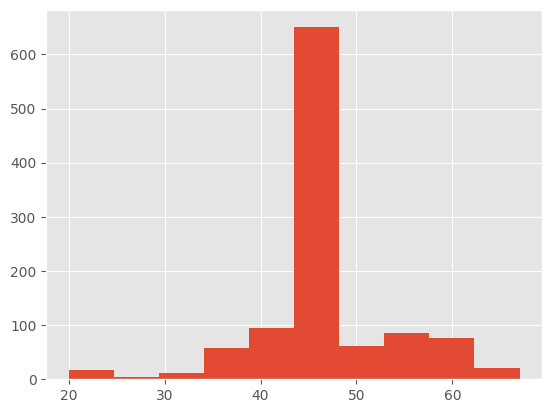

In [17]:
df["Eta' utente"][df["Tipo utente"] == 'NON OCCUPATO'].hist()

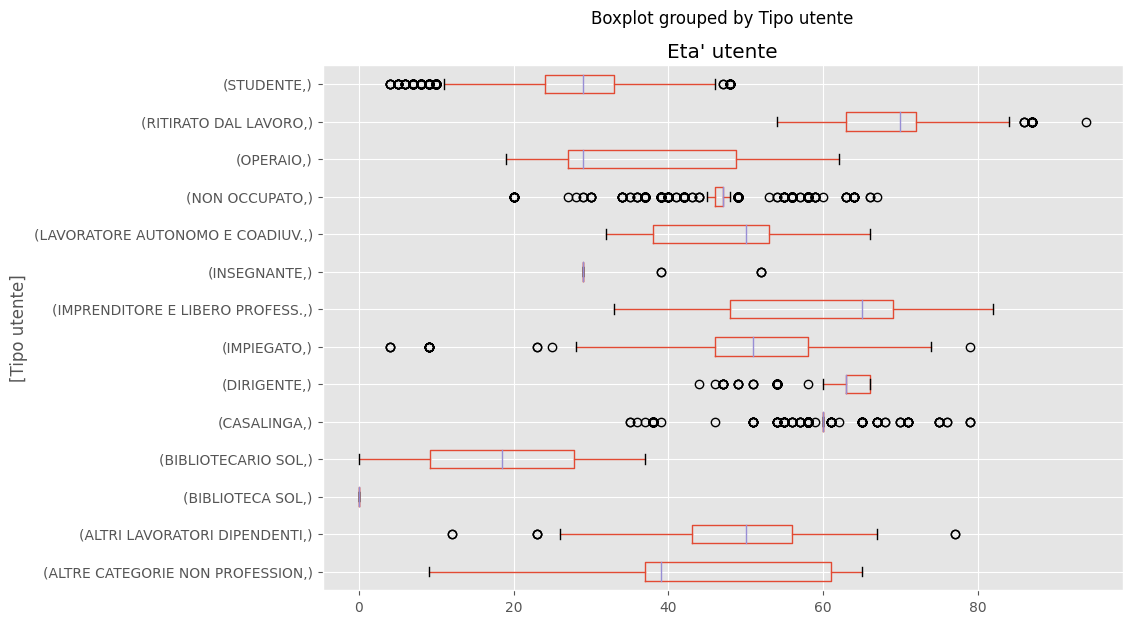

In [10]:
boxplot = df.boxplot(column=["Eta' utente"], by=["Tipo utente"], figsize=(10,7), vert=False)

In [18]:
# BERTopic requires a list as input
comments = df['Descrizione commento'].tolist()
comments[:3]

['Libro consigliato a tutti coloro che vogliono o devono analizzare la prima raccolta di Ungaretti.\nIl commento ad ogni poesia è fin troppo esaustivo.\nLa pecca probabilmente è nel linguaggio esageratamente forbito di Ossola.\nUso insistito di parole complesse e poco conosciuto; citazione in francesce senza la traduzione (non tutti sanno capire il francese), uso volutissimo del latino: hit e nunc, editio princeps, omoioteleutos e così via. ogni tanto bisogna fermarsi e cercare il significato di certe parole, altrimenti la lettura è molto complessa.',
 "Un volumetto davvero prezioso che raccoglie epistole e poesie di una personalità cruciale del panorama artistico italiano degli anni '20. Coinvolgente la prefazione di Amelia Rosselli che considerò sempre Scipione un grandissimo poeta, benché nella sua purtroppo breve parabola artistica non avesse composto più di una diecina di poesie. Nelle composizioni di Scipione l'uomo, quasi primitivo, è in un dialogo costante con la terra e le sue

In [19]:
# {Maarten Grootendorst} https://github.com/MaartenGr/BERTopic
# BERTopic is a topic modeling technique that leverages transformers and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions. It even supports visualizations similar to LDAvis!

topic_model = BERTopic(language="italian", calculate_probabilities=True, verbose=True)
topic_model


In [20]:
topics, probs = topic_model.fit_transform(comments)

Batches: 100%|███████████████████████████████████████████████████████████████████████| 591/591 [00:27<00:00, 21.31it/s]
2024-10-24 14:14:45,358 - BERTopic - Transformed documents to Embeddings
2024-10-24 14:15:22,180 - BERTopic - Reduced dimensionality
2024-10-24 14:15:47,903 - BERTopic - Clustered reduced embeddings


In [30]:
len(comments), len(topics) # at each comment a topic is associated

(18905, 18905)

In [22]:
unique_topics = set(topics) # unique topics discovered by the model
len(unique_topics)

153

In [32]:
comments[18904],topics[18904], probs[18904] # association probabilities of each of the unique_topics to one specific comment  

("Che gli italiani siano cambiati, e non proprio in bene, è ormai un dato di fatto. Quella mutazione antropologica intuita da Pier Paolo Pasolini a metà degli anni Settanta è oggi ben più evidente e con tratti forse peggiori. E se in tutto l'Occidente si sono incrinate le democrazie e prevale un individualismo spaventato e consumista, l'Italia ha anticipato molti dei processi che oggi ci fanno guardare con sguardo preoccupato e disarmato l'involuzione civile che attraversa gli Stati Uniti e larga parte dell'Europa. Una deriva che parte da lontano, e cioè da quel 1989 che non solo non ha mantenuto le sue promesse ma ha segnato l'avvio di una nuova e spesso spietata globalizzazione del pianeta. In questo senso l'immigrazione è davvero il fenomeno che in modo più evidente permette di leggere il cambiamento delle culture degli italiani. Non l'unico, ovviamente. Ma l'immigrazione svolge una «funzione specchio» capace di rivelare la natura della società di accoglienza, portando alla luce ciò

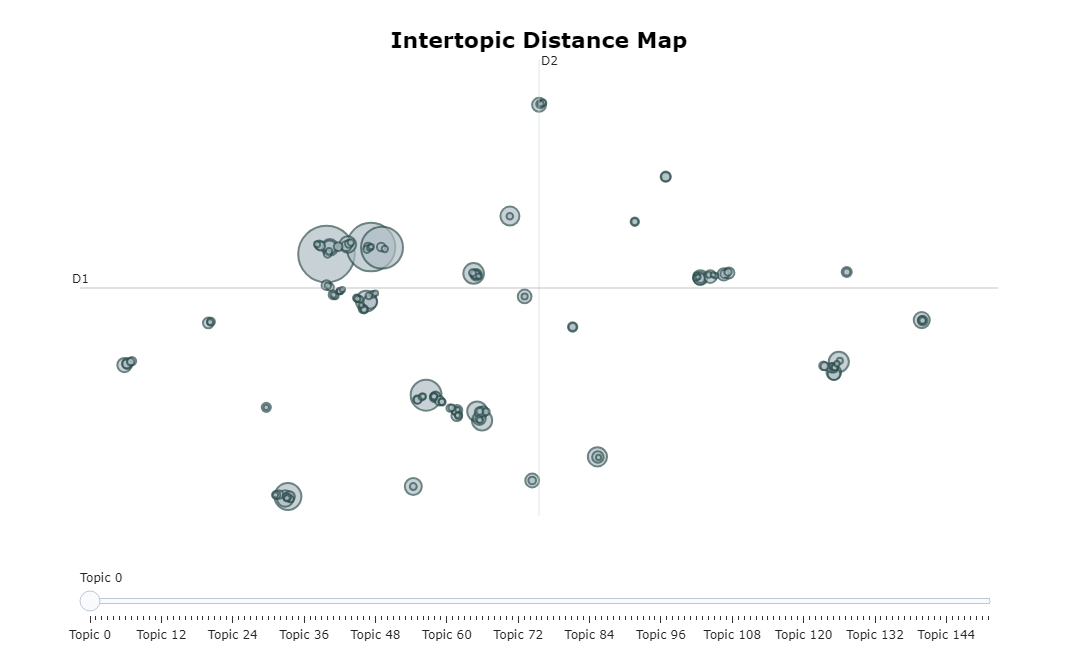

In [33]:
# import nbformat
# print(nbformat.__version__)

topic_model.visualize_topics()

In [34]:
topics_pivot = topic_model.get_topic_info()
topics_pivot


Topic  Count                                      Name  \
0       -1  10399                           -1_di_che_la_un   
1        0   1198                  0_film_regista_attori_un   
2        1    884                      1_libro_ho_mi_questo   
3        2    658           2_bambini_libro_bambino_ragazzi   
4        3    357              3_commissario_omicidio_il_un   
..     ...    ...                                       ...   
148    147     10  147_manzini_editoria_codignola_scrittori   
149    148     10       148_darwin_marx_evoluzione_formiche   
150    149     10           149_guerra_soldati_nemico_paura   
151    150     10     150_pirati_mare_affascinandolo_voodoo   
152    151     10                  151_seo_web_sito_keyword   

                                        Representation  \
0         [di, che, la, un, il, in, una, non, per, si]   
1    [film, regista, attori, un, il, del, da, che, ...   
2    [libro, ho, mi, questo, letto, libri, non, mol...   
3    [bambini, libro, bambino, ragazzi, molto, ai, ...   
4    [commissario, omicidio, il, un, di, indagine, ...   
..                                                 ...   
148  [manzini, editoria, codignola, scrittori, erba...   
149  [darwin, marx, evoluzione, formiche, dinosauri...   
150  [guerra, soldati, nemico, paura, trincea, gent...   
151  [pirati, mare, affascinandolo, voodoo, topos, ...   
152  [seo, web, sito, keyword, framework, research,...   

                                   Representative_Docs  
0    [Può sembrare sbagliato esprimersi in questi t...  
1    [Il film è un vero capolavoro non solo sul pia...  
2    [Il romanzo si apprezza in tutta la sua bellez...  
3    [una storia dolce di un rapporto tenero fra ma...  
4    [Sottile il gioco psicologico con cui l'autore...  
..                                                 ...  
148  [Ero scettico su questo libro. Pensavo fosse l...  
149  [Operazione singolare quella di recensire "ade...  
150  [La guerra, dimentichiamo che la guerra non è ...  
151  [Graphic novel splendida, dedicata al mare e a...  
152  [Il libro parla del processo di progettazione ...  

[153 rows x 5 columns]

In [35]:
events_count = topics_pivot['Count'].sum() # sum of all topics counts
events_count


18905

In [36]:
def calc_perc(row):
    return round(row['Count']*100/events_count, 2)

topics_pivot['Perc'] = topics_pivot.apply (lambda row: calc_perc(row), axis=1)
topics_pivot

Topic  Count                                      Name  \
0       -1  10399                           -1_di_che_la_un   
1        0   1198                  0_film_regista_attori_un   
2        1    884                      1_libro_ho_mi_questo   
3        2    658           2_bambini_libro_bambino_ragazzi   
4        3    357              3_commissario_omicidio_il_un   
..     ...    ...                                       ...   
148    147     10  147_manzini_editoria_codignola_scrittori   
149    148     10       148_darwin_marx_evoluzione_formiche   
150    149     10           149_guerra_soldati_nemico_paura   
151    150     10     150_pirati_mare_affascinandolo_voodoo   
152    151     10                  151_seo_web_sito_keyword   

                                        Representation  \
0         [di, che, la, un, il, in, una, non, per, si]   
1    [film, regista, attori, un, il, del, da, che, ...   
2    [libro, ho, mi, questo, letto, libri, non, mol...   
3    [bambini, libro, bambino, ragazzi, molto, ai, ...   
4    [commissario, omicidio, il, un, di, indagine, ...   
..                                                 ...   
148  [manzini, editoria, codignola, scrittori, erba...   
149  [darwin, marx, evoluzione, formiche, dinosauri...   
150  [guerra, soldati, nemico, paura, trincea, gent...   
151  [pirati, mare, affascinandolo, voodoo, topos, ...   
152  [seo, web, sito, keyword, framework, research,...   

                                   Representative_Docs   Perc  
0    [Può sembrare sbagliato esprimersi in questi t...  55.01  
1    [Il film è un vero capolavoro non solo sul pia...   6.34  
2    [Il romanzo si apprezza in tutta la sua bellez...   4.68  
3    [una storia dolce di un rapporto tenero fra ma...   3.48  
4    [Sottile il gioco psicologico con cui l'autore...   1.89  
..                                                 ...    ...  
148  [Ero scettico su questo libro. Pensavo fosse l...   0.05  
149  [Operazione singolare quella di recensire "ade...   0.05  
150  [La guerra, dimentichiamo che la guerra non è ...   0.05  
151  [Graphic novel splendida, dedicata al mare e a...   0.05  
152  [Il libro parla del processo di progettazione ...   0.05  

[153 rows x 6 columns]

In [37]:
# we observe the first 25 topics
top_topics = 25

topics_pivot.head(top_topics).drop([0])

Topic  Count                                      Name  \
1       0   1198                  0_film_regista_attori_un   
2       1    884                      1_libro_ho_mi_questo   
3       2    658           2_bambini_libro_bambino_ragazzi   
4       3    357              3_commissario_omicidio_il_un   
5       4    270                4_donne_femminile_donna_le   
6       5    161    5_giapponese_giappone_tokyo_giapponesi   
7       6    159                    6_amore_storia_due_che   
8       7    153                7_roma_città_romana_romani   
9       8    152                8_russia_russa_russi_russo   
10      9    149             9_italia_italiana_italiano_in   
11     10    138        10_hitler_nazista_nazisti_germania   
12     11    135    11_bello_bellissimo_molto_interessante   
13     12    108                    12_padre_madre_lei_una   
14     13    103               13_anna_alice_eleanor_amore   
15     14    103           14_lettura_leggere_piacevole_da   
16     15    103       15_personaggi_finale_thriller_trama   
17     16     97        16_economia_economica_politica_del   
18     17     82             17_palestinese_arabo_pag_iran   
19     18     81  18_fisica_matematica_quantistica_scienza   
20     19     76        19_divertente_ride_risate_commedia   
21     20     73            20_brani_musica_orchestra_bach   
22     21     72                21_cinese_cina_chen_cinesi   
23     22     72            22_padre_figlio_figli_telemaco   
24     23     70           23_piante_alberi_vegetale_bosco   

                                       Representation  \
1   [film, regista, attori, un, il, del, da, che, ...   
2   [libro, ho, mi, questo, letto, libri, non, mol...   
3   [bambini, libro, bambino, ragazzi, molto, ai, ...   
4   [commissario, omicidio, il, un, di, indagine, ...   
5   [donne, femminile, donna, le, loro, uomini, la...   
6   [giapponese, giappone, tokyo, giapponesi, paes...   
7   [amore, storia, due, che, una, un, donna, ma, ...   
8   [roma, città, romana, romani, venezia, di, del...   
9   [russia, russa, russi, russo, dostoevskij, di,...   
10  [italia, italiana, italiano, in, da, per, di, ...   
11  [hitler, nazista, nazisti, germania, tedeschi,...   
12  [bello, bellissimo, molto, interessante, inten...   
13  [padre, madre, lei, una, sua, la, ha, suo, con...   
14  [anna, alice, eleanor, amore, protagonista, su...   
15  [lettura, leggere, piacevole, da, ombrellone, ...   
16  [personaggi, finale, thriller, trama, non, ser...   
17  [economia, economica, politica, del, delle, le...   
18  [palestinese, arabo, pag, iran, palestina, isr...   
19  [fisica, matematica, quantistica, scienza, sci...   
20  [divertente, ride, risate, commedia, parodia, ...   
21  [brani, musica, orchestra, bach, ascolto, comp...   
22  [cinese, cina, chen, cinesi, cao, partito, cul...   
23  [padre, figlio, figli, telemaco, padri, famigl...   
24  [piante, alberi, vegetale, bosco, mancuso, viv...   

                                  Representative_Docs  Perc  
1   [Il film è un vero capolavoro non solo sul pia...  6.34  
2   [Il romanzo si apprezza in tutta la sua bellez...  4.68  
3   [una storia dolce di un rapporto tenero fra ma...  3.48  
4   [Sottile il gioco psicologico con cui l'autore...  1.89  
5   ["Tutto era pieno di Egon, delle sue passioni,...  1.43  
6   [Il Giappone è una realtà estremamente comples...  0.85  
7   [bellissima storia d'amore, Scritto benissimo ...  0.84  
8   [La Roma del romanzo è decisamente diversa da ...  0.81  
9   [Questo libro, che l'estroso Paolo Nori non co...  0.80  
10  [SI può apprezzare su più fronti questa pubbli...  0.79  
11  [HHhH in realtà è ben più della storia di Heyd...  0.73  
12  [Molto bello , Molto bello e interessante, Mol...  0.71  
13  [Lina è una bambina quando la madre emigra in ...  0.57  
14  [un capolavoro... certo non e' il libro- fiume...  0.54  
15  [da leggere, scorrevole e ben scritto, lettura...  0.54  
16  [Si tratta di un thriller scrit

In [38]:
# we use np.linspace(0, 1, top_topics) instead of a simple range like range(0, top_topics) is because color maps in Matplotlib, such as plt.cm.rainbow, expect input values in the range [0, 1]. These input values are then mapped to colors in the color map

colors = plt.cm.rainbow(np.linspace(0, 1, top_topics))
colors

array([[5.00000000e-01, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [4.21568627e-01, 1.22888291e-01, 9.98103329e-01, 1.00000000e+00],
       [3.35294118e-01, 2.55842778e-01, 9.91644696e-01, 1.00000000e+00],
       [2.49019608e-01, 3.84105749e-01, 9.80634770e-01, 1.00000000e+00],
       [1.70588235e-01, 4.94655843e-01, 9.66718404e-01, 1.00000000e+00],
       [8.43137255e-02, 6.07538946e-01, 9.47177357e-01, 1.00000000e+00],
       [1.96078431e-03, 7.09281308e-01, 9.23289106e-01, 1.00000000e+00],
       [8.03921569e-02, 7.90532412e-01, 8.97892032e-01, 1.00000000e+00],
       [1.66666667e-01, 8.66025404e-01, 8.66025404e-01, 1.00000000e+00],
       [2.52941176e-01, 9.25637660e-01, 8.30184031e-01, 1.00000000e+00],
       [3.31372549e-01, 9.65124085e-01, 7.94289890e-01, 1.00000000e+00],
       [4.17647059e-01, 9.91644696e-01, 7.51331890e-01, 1.00000000e+00],
       [5.03921569e-01, 9.99981027e-01, 7.04925547e-01, 1.00000000e+00],
       [5.82352941e-01, 9.91644696e-01, 6.59924535e

In [39]:
# iterator that you can loop over to access each color in the colors list one at a time

iter_color = iter(colors)
iter_color

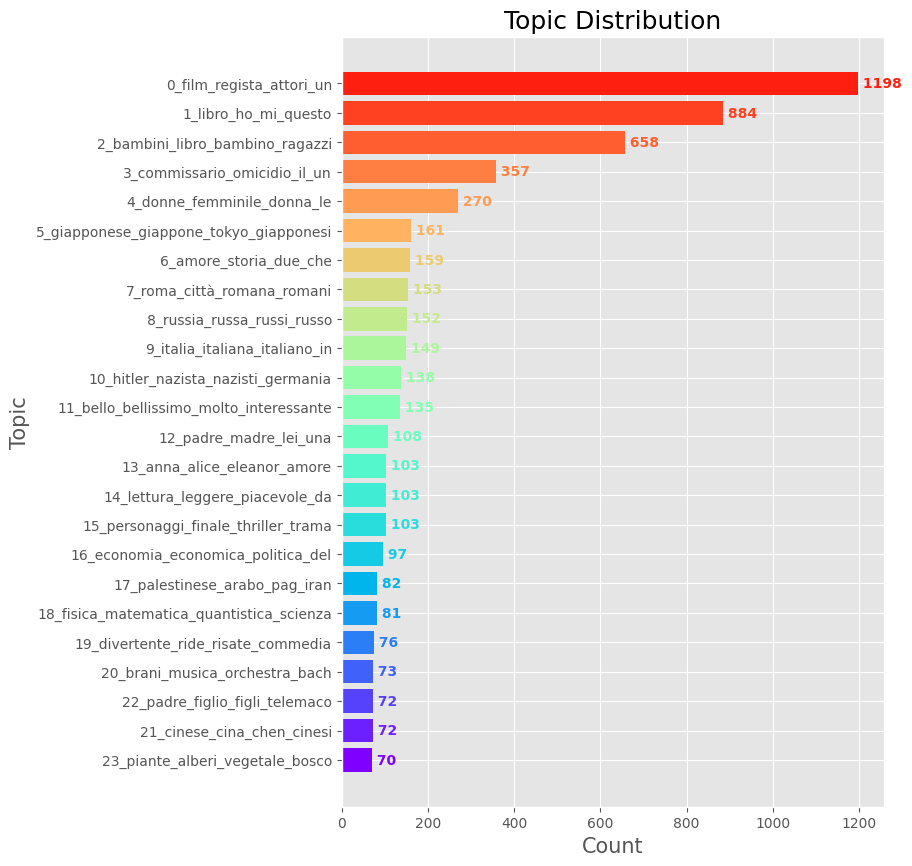

In [40]:
fig = plt.figure(figsize=(7,10))

plt.barh('Name', 'Count',
         data=topics_pivot.head(top_topics).drop([0]).sort_values('Count',ascending=True), color=colors)
plt.xlabel("Count", size=15)
plt.ylabel("Topic", size=15)
plt.title("Topic Distribution", size=18)

# to visualize the count of topics at the end of the bar
for i, v in enumerate(topics_pivot.head(top_topics).drop([0])["Count"].sort_values(ascending=True)):
    c = next(iter_color)
    plt.text(v, i, " "+str(v), color=c, va='center', fontweight='bold')

In [41]:
df['topics'] = topics
df.head(3)

Punteggio utente sul titolo Id. commento Punteggio medio titolo  \
0                           4          138                 4.0000   
1                        None         3567                   None   
2                        None         3653                   None   

  Cod. tipo materiale            Tipo documento Identificativo titolo  \
0                   M  Testo a stampa (moderno)                    91   
1                   M  Testo a stampa (moderno)                   208   
2                   M  Testo a stampa (moderno)                   429   

   Eta' utente Tipo utente Anno di pubblicazione    CAP Tipo materiale  \
0           31    STUDENTE                  1990  00148  Libro moderno   
1           33    STUDENTE                  1982  04011  Libro moderno   
2           33    STUDENTE                  1990  04011  Libro moderno   

  Lingua 3 Lingua 2      Natura  \
0                    Monografia   
1                    Monografia   
2                    Monografia   

                                Descrizione commento  Lingua 1  \
0  Libro consigliato a tutti coloro che vogliono ...  ITALIANO   
1  Un volumetto davvero prezioso che raccoglie ep...  ITALIANO   
2  Terzo volumetto di Pizzi. I versi si rincorron...  ITALIANO   

  Cod. tipo utente Cod. Lingua 1 Cod. natura Cod. Lingua 3 Cod. Lingua 2  \
0                S           ITA           M                               
1                S           ITA           M                               
2                S           ITA           M                               

  Cod. tipo documento                                             Titolo  \
0                  LM  Il *porto sepolto / Giuseppe Ungaretti ; a cur...   
1                  LM  *Carte segrete / Scipione ; prefazione di Amel...   
2                  LM  *Acquerugiole / Marina Pizzi. - Milano : Croce...   

                                     Titolo commento Data commento  topics  
0  Interpretazione ed analisi scritta benissimo, ...    2011/02/23      -1  
1                              Testi rari e preziosi    2018/08/28      -1  
2                   "Genuflesse finanche le parole"     2018/08/31      -1

In [23]:
'''
We perform sentiment analysis over the readers reviews to determine whether a comment is positive or negative by using the feel-it-italian-sentiment⁸ model, available on HuggingFace⁹.

The model fine-tuned the UmBERTo¹⁰ model on a new dataset: FEEL-IT, a novel benchmark corpus of Italian Twitter posts.
'''

'\nWe perform sentiment analysis over the readers reviews to determine whether a comment is positive or negative by using the feel-it-italian-sentiment⁸ model, available on HuggingFace⁹.\n\nThe model fine-tuned the UmBERTo¹⁰ model on a new dataset: FEEL-IT, a novel benchmark corpus of Italian Twitter posts.\n'

In [42]:
# From: https://huggingface.co/MilaNLProc/feel-it-italian-sentiment
# Sentiment Analysis

# to load the tokenizer associated with the model. A tokenizer is responsible for preparing the inputs for a model
tokenizer = AutoTokenizer.from_pretrained("MilaNLProc/feel-it-italian-sentiment")

# to load the pre-trained model. This model can be used for tasks like sentiment analysis or emotion classification
model_sentiment = AutoModelForSequenceClassification.from_pretrained("MilaNLProc/feel-it-italian-sentiment")

def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt") # It tokenizes the input text and prepares it for the model.
# In PyTorch, squeeze() and unsqueeze() are used to adjust the dimensions of a tensor, adding or removing dimension of size 1
    labels = torch.tensor([1]).unsqueeze(0) # It creates a tensor for the labels. In this case, it seems like you’re always using a label of 1, which might correspond to a “positive” sentiment.
    outputs = model_sentiment(**inputs, labels=labels) # It feeds the inputs and labels to the model, which returns the loss and logits.
    loss, logits = outputs[:2]
    logits = logits.squeeze(0)

    proba = torch.nn.functional.softmax(logits, dim=0) # It applies the softmax function to the logits to get probabilities.
    value, index = torch.topk(proba,1) # It uses torch.topk to get the highest probability and its index.

# Depending on the index, it either returns the highest probability (if the index is 1) or 1 minus the highest probability (if the index is not 1). This is based on the assumption that you’re dealing with binary classification (positive vs negative sentiment), and that the probabilities of both classes sum up to 1.
    # class = "Positive" if np.round(index.item()) == 1 else "Negative" 
    # binary classification: P(negative) = 1 - P(positive)
    p = np.round(value.item(), decimals=4) if np.round(index.item()) == 1 else np.round((1-value.item()), decimals=4)

    return p

In [43]:
# We can test the model output on few sentences:

p = predict_sentiment("libro non male ma sconsigliato ad un pubblico maturo")

print("Example: 'libro non male ma sconsigliato ad un pubblico maturo' (The book is not bad, but I would not recommend it to a mature audience)")
print("Sentiment: ", "Positive" if round(p)==1 else "Negative")
print("P(Positive): ", str(p))
print()

p = predict_sentiment("non ricordo l ultimo libro così bello da non farmi dormire la notte")

print("Example: 'non ricordo l ultimo libro così bello da non farmi dormire la notte' (I do not remember such a wonderful book to keep me awake at night)")
print("Sentiment: ", "Positive" if round(p)==1 else "Negative")
print("P(Positive): ", str(p))
print()

p = predict_sentiment("non ho tante idee da menzionare in questo commento, non so se lo faró")

print("Example: 'non ho tante idee da menzionare in questo commento, non so se lo faró")
print("Sentiment: ", "Positive" if round(p)==1 else "Negative")
print("P(Positive): ", str(p))

Example: 'libro non male ma sconsigliato ad un pubblico maturo' (The book is not bad, but I would not recommend it to a mature audience)
Sentiment:  Negative
P(Positive):  0.0009

Example: 'non ricordo l ultimo libro così bello da non farmi dormire la notte' (I do not remember such a wonderful book to keep me awake at night)
Sentiment:  Positive
P(Positive):  0.9998

Example: 'non ho tante idee da menzionare in questo commento, non so se lo faró
Sentiment:  Positive
P(Positive):  0.9997


In [44]:
# In many cases, the sentiment of a text can be determined from the first few words or sentences, and including more words might not significantly improve the accuracy of the sentiment prediction. By limiting the input to the first 30 words, the code can run faster and use less memory, which can be important when processing large datasets.

# word separator (space)
sep = ' '

# max number of words from each comment
# to be used for sentiment analysis
max_w = 30

# create new df column with P(Positive)
df["sentiment"] = [predict_sentiment(sep.join(i.split()[:max_w])) for i in comments]
df.head(3)

Punteggio utente sul titolo Id. commento Punteggio medio titolo  \
0                           4          138                 4.0000   
1                        None         3567                   None   
2                        None         3653                   None   

  Cod. tipo materiale            Tipo documento Identificativo titolo  \
0                   M  Testo a stampa (moderno)                    91   
1                   M  Testo a stampa (moderno)                   208   
2                   M  Testo a stampa (moderno)                   429   

   Eta' utente Tipo utente Anno di pubblicazione    CAP Tipo materiale  \
0           31    STUDENTE                  1990  00148  Libro moderno   
1           33    STUDENTE                  1982  04011  Libro moderno   
2           33    STUDENTE                  1990  04011  Libro moderno   

  Lingua 3 Lingua 2      Natura  \
0                    Monografia   
1                    Monografia   
2                    Monografia   

                                Descrizione commento  Lingua 1  \
0  Libro consigliato a tutti coloro che vogliono ...  ITALIANO   
1  Un volumetto davvero prezioso che raccoglie ep...  ITALIANO   
2  Terzo volumetto di Pizzi. I versi si rincorron...  ITALIANO   

  Cod. tipo utente Cod. Lingua 1 Cod. natura Cod. Lingua 3 Cod. Lingua 2  \
0                S           ITA           M                               
1                S           ITA           M                               
2                S           ITA           M                               

  Cod. tipo documento                                             Titolo  \
0                  LM  Il *porto sepolto / Giuseppe Ungaretti ; a cur...   
1                  LM  *Carte segrete / Scipione ; prefazione di Amel...   
2                  LM  *Acquerugiole / Marina Pizzi. - Milano : Croce...   

                                     Titolo commento Data commento  topics  \
0  Interpretazione ed analisi scritta benissimo, ...    2011/02/23      -1   
1                              Testi rari e preziosi    2018/08/28      -1   
2                   "Genuflesse finanche le parole"     2018/08/31      -1   

   sentiment  
0     0.9880  
1     0.9997  
2     0.9997

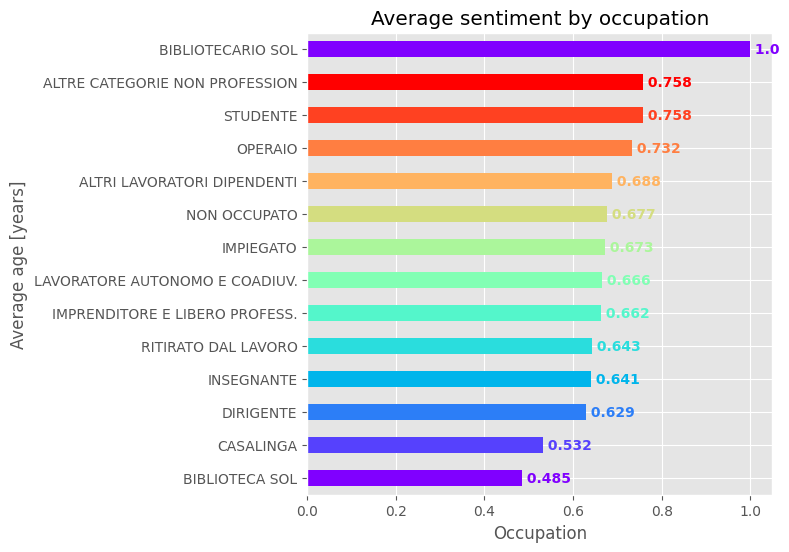

In [49]:
# average sentiment by readers occupation




df.groupby("Tipo utente")["sentiment"].mean().sort_values(ascending=True).plot.barh(title="Average sentiment by occupation",
                                                                                    xlabel="Occupation",
                                                                                    ylabel="Average age [years]",
                                                                                    color=colors,
                                                                                    figsize=(6,6))

    
colors = plt.cm.rainbow(np.linspace(0, 1, 13))
# iter_color = iter(colors)
iter_color = itertools.cycle(colors)
for i, v in enumerate(df.groupby("Tipo utente")["sentiment"].mean().sort_values(ascending=True)):
    c = next(iter_color)
    plt.text(v, i, " "+str(round(v,3)), color=c, va='center', fontweight='bold')


In [ ]:
'''
We now perform customers’ clustering based on their characteristics (age and occupation) in order to later implement recommendations in absence of preferred topics or interests.
'''

In [50]:

# imputing missing ages with their mean
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

# fitting the imputation model
imp.fit(df[["Eta' utente"]])

# applying the model
imputations = pd.Series(imp.transform(df[["Eta' utente"]]).flatten())
imputations


0        31.0
1        33.0
2        33.0
3        33.0
4        43.0
         ... 
18900    69.0
18901    60.0
18902    47.0
18903    60.0
18904    47.0
Length: 18905, dtype: float64

In [51]:
imputations.value_counts()

63.0    979
60.0    952
47.0    865
53.0    767
33.0    655
       ... 
80.0      4
86.0      3
94.0      1
81.0      1
84.0      1
Name: count, Length: 85, dtype: int64

In [52]:
df[["Eta' utente"]].value_counts()

Eta' utente
63             979
60             952
47             865
53             767
46             655
              ... 
80               4
86               3
81               1
84               1
94               1
Name: count, Length: 85, dtype: int64

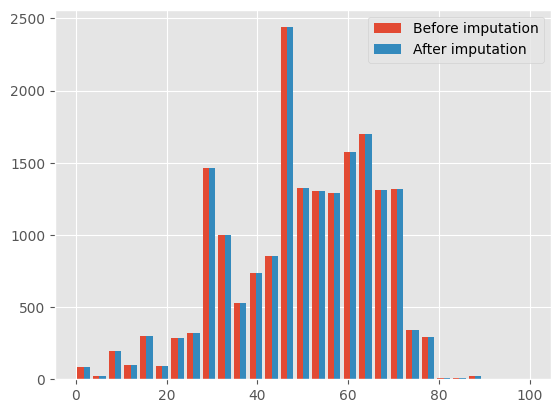

In [53]:
# comparing distributions
bins = np.linspace(0, 100, 30)
plt.hist([df["Eta' utente"], imputations], bins, label=['Before imputation', 'After imputation'])
plt.legend(loc='upper right')
plt.show()

In [54]:
# updating df column with imputed values
df["Eta' utente"] = imputations

In [55]:
# We check whether the age is normally distributed through the Shapiro test:

def isgaussian(data, alpha=0.05):
    stat, p = shapiro(data)
    return True if p > alpha else False


In [56]:
isgaussian(df["Eta' utente"])
# False

False

In [60]:
# We use the elbow method to determine the number of clusters:

def plot_elbow(start, end, data):
    colors = iter(plt.cm.rainbow(np.linspace(0, 1, end+1-start)))
    n_clus = list(range(start, end+1))
    costs = []

    plt.figure(figsize=(15, 7))

    for k in n_clus:
        c = next(colors)
        model = KPrototypes(n_clusters=k, init='Huang', random_state=42)
        model.fit_predict(data, categorical=[1])
        costs.append(model.cost_)
        print('Executing for',k,'clusters..')
        plt.plot(k,
                model.cost_,
                color=c,
                label='n° clusters: {}'.format(k),
                marker='o',
                markersize=12,
                markeredgecolor='black',
                markeredgewidth=2)

    plt.plot(n_clus, costs, 'k--')
    plt.xlabel('N° of clusters')
    plt.ylabel('Cost')
    plt.title('Elbow curve')


Executing for 2 clusters
Executing for 3 clusters
Executing for 4 clusters
Executing for 5 clusters
Executing for 6 clusters
Executing for 7 clusters
Executing for 8 clusters
Executing for 9 clusters


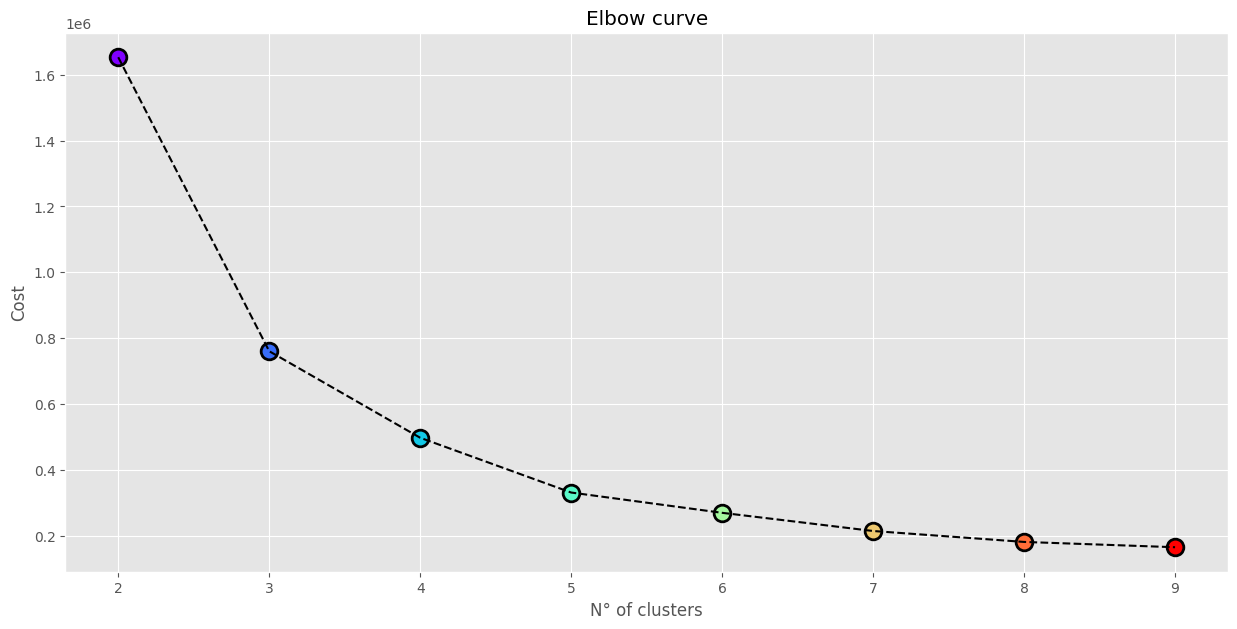

In [61]:
plot_elbow(2, 7, df[["Eta' utente","Tipo utente"]])

In [62]:
df[["Eta' utente","Tipo utente"]]

Eta' utente                  Tipo utente
0             31.0                     STUDENTE
1             33.0                     STUDENTE
2             33.0                     STUDENTE
3             33.0                     STUDENTE
4             43.0  ALTRI LAVORATORI DIPENDENTI
...            ...                          ...
18900         69.0          RITIRATO DAL LAVORO
18901         60.0                    CASALINGA
18902         47.0                 NON OCCUPATO
18903         60.0                    CASALINGA
18904         47.0                 NON OCCUPATO

[18905 rows x 2 columns]

In [63]:
# fitting model with best number of clusters (4) based on the elbow curve
clus_model = KPrototypes(n_clusters=4, init='Huang', random_state=42)
clusters= clus_model.fit_predict(df[["Eta' utente","Tipo utente"]], categorical=[1])

In [64]:
clusters

array([2, 2, 2, ..., 0, 1, 0], dtype=uint16)

In [65]:
# adding clusters column to the dataframe
df.insert(0, "clusters", clusters, True)
df.head(3)

clusters Punteggio utente sul titolo Id. commento Punteggio medio titolo  \
0         2                           4          138                 4.0000   
1         2                        None         3567                   None   
2         2                        None         3653                   None   

  Cod. tipo materiale            Tipo documento Identificativo titolo  \
0                   M  Testo a stampa (moderno)                    91   
1                   M  Testo a stampa (moderno)                   208   
2                   M  Testo a stampa (moderno)                   429   

   Eta' utente Tipo utente Anno di pubblicazione    CAP Tipo materiale  \
0         31.0    STUDENTE                  1990  00148  Libro moderno   
1         33.0    STUDENTE                  1982  04011  Libro moderno   
2         33.0    STUDENTE                  1990  04011  Libro moderno   

  Lingua 3 Lingua 2      Natura  \
0                    Monografia   
1                    Monografia   
2                    Monografia   

                                Descrizione commento  Lingua 1  \
0  Libro consigliato a tutti coloro che vogliono ...  ITALIANO   
1  Un volumetto davvero prezioso che raccoglie ep...  ITALIANO   
2  Terzo volumetto di Pizzi. I versi si rincorron...  ITALIANO   

  Cod. tipo utente Cod. Lingua 1 Cod. natura Cod. Lingua 3 Cod. Lingua 2  \
0                S           ITA           M                               
1                S           ITA           M                               
2                S           ITA           M                               

  Cod. tipo documento                                             Titolo  \
0                  LM  Il *porto sepolto / Giuseppe Ungaretti ; a cur...   
1                  LM  *Carte segrete / Scipione ; prefazione di Amel...   
2                  LM  *Acquerugiole / Marina Pizzi. - Milano : Croce...   

                                     Titolo commento Data commento  topics  \
0  Interpretazione ed analisi scritta benissimo, ...    2011/02/23      -1   
1                              Testi rari e preziosi    2018/08/28      -1   
2                   "Genuflesse finanche le parole"     2018/08/31      -1   

   sentiment  
0     0.9880  
1     0.9997  
2     0.9997

In [66]:
# We can now inspect the obtained clusters, by observing the age distribution and the most recurrent (and the second most recurrent) occupations within each cluster:

pd.set_option('display.max_colwidth', None)

df.groupby(['clusters'])[["Eta' utente", "Tipo utente"]].agg({"Eta' utente" : ['count', 
                                                                               'mean',
                                                                               'std',
                                                                               'min',
                                                                               'max'], 
                                                              'Tipo utente' : [lambda x: str(x.value_counts().to_frame().iloc[[0]]).replace("count\nTipo utente", "").replace("\n", "") + " (" + str(round(x.value_counts().to_frame().iloc[0][0]*100/ x.count(), 2)) + '%)',
                                                                               lambda x: str(x.value_counts().to_frame().iloc[[1]]).replace("count\nTipo utente", "").replace("\n", "") + " (" + str(round(x.value_counts().to_frame().iloc[1][0]*100/ x.count(), 2)) + '%)'                                                                        
                                                                               ]})

Eta' utente                                   \
               count       mean       std   min   max   
clusters                                                
0               6681  49.194133  4.140519  41.0  57.0   
1               7143  65.534509  5.260203  58.0  94.0   
2               4058  32.356087  4.086942  24.0  41.0   
3               1023  14.015640  6.458641   0.0  23.0   

                                                                     Tipo utente  \
                                                                      <lambda_0>   
clusters                                                                           
0                                                    IMPIEGATO     3930 (58.82%)   
1                                             RITIRATO DAL LAVORO   2064 (28.9%)   
2                                                    STUDENTE      2611 (64.34%)   
3                                                    STUDENTE       879 (85.92%)   

                                                                   
                                                       <lambda_1>  
clusters                                                           
0                                     NON OCCUPATO    835 (12.5%)  
1                                      IMPIEGATO     1693 (23.7%)  
2                                     IMPIEGATO      415 (10.23%)  
3                                   BIBLIOTECA SOL     82 (8.02%)

In [67]:
df.groupby(['Tipo utente'])["clusters"].value_counts()

Tipo utente                     clusters
ALTRE CATEGORIE NON PROFESSION  2             74
                                1             39
                                3             22
                                0             13
ALTRI LAVORATORI DIPENDENTI     0            640
                                2            246
                                1            193
                                3              5
BIBLIOTECA SOL                  3             82
BIBLIOTECARIO SOL               2              1
                                3              1
CASALINGA                       1            888
                                2             48
                                0             45
DIRIGENTE                       1            507
                                0             54
IMPIEGATO                       0           3930
                                1           1693
                                2            415
                            

In [68]:
df.groupby(['Tipo utente'])["clusters"].value_counts().unstack(fill_value=0)

clusters                           0     1     2    3
Tipo utente                                          
ALTRE CATEGORIE NON PROFESSION    13    39    74   22
ALTRI LAVORATORI DIPENDENTI      640   193   246    5
BIBLIOTECA SOL                     0     0     0   82
BIBLIOTECARIO SOL                  0     0     1    1
CASALINGA                         45   888    48    0
DIRIGENTE                         54   507     0    0
IMPIEGATO                       3930  1693   415   16
IMPRENDITORE E LIBERO PROFESS.   624  1633   154    0
INSEGNANTE                         3     0    95    0
LAVORATORE AUTONOMO E COADIUV.   366    27   248    0
NON OCCUPATO                     835    97   130   17
OPERAIO                           13     2    36    1
RITIRATO DAL LAVORO                1  2064     0    0
STUDENTE                         157     0  2611  879

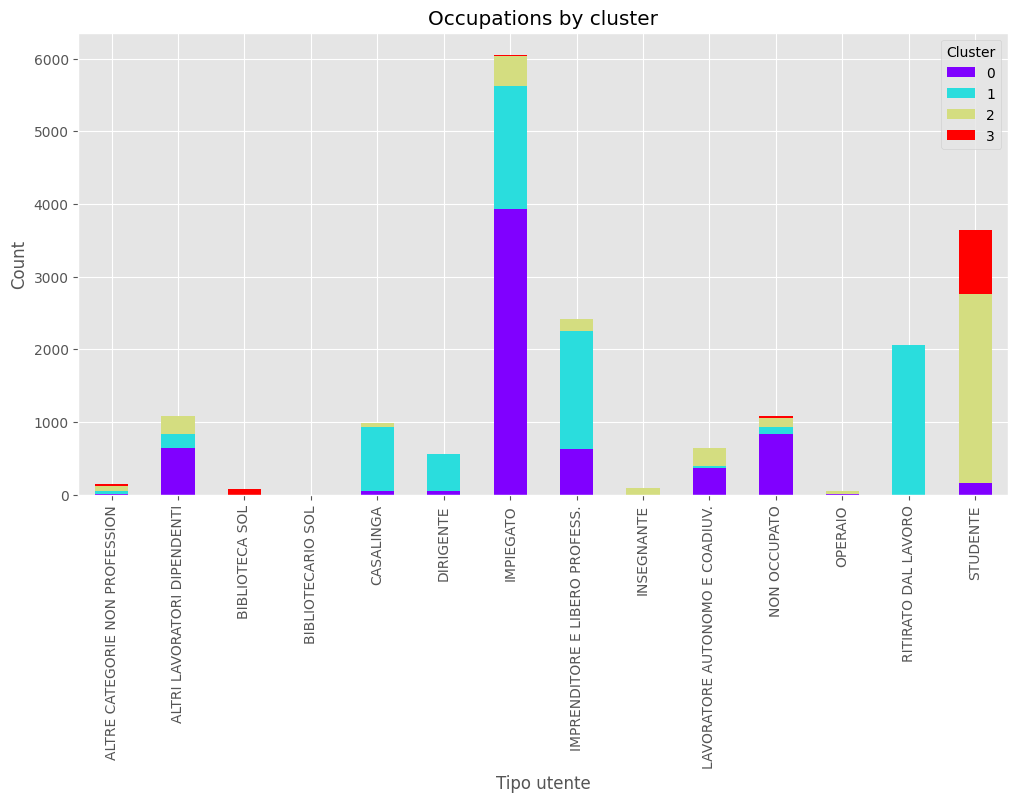

In [75]:
# # The distribution of occupations by cluster can also be visually inspected:


# ax = df.groupby(['Tipo utente'])["clusters"].value_counts().unstack(fill_value=0).plot(kind='pie', 
#                                                                                        autopct='%1.0f%%',
#                                                                                        figsize=(40, 7),
#                                                                                        colors = plt.cm.rainbow(np.linspace(0, 1, 10)), 
#                                                                                        subplots=True,
#                                                                                        legend=False,
#                                                                                        title='Occupations by cluster')



data = df.groupby(['Tipo utente', 'clusters']).size().unstack(fill_value=0)

# Plot the stacked bar chart
data.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='rainbow')
plt.title('Occupations by cluster')
plt.xlabel('Tipo utente')
plt.ylabel('Count')
plt.legend(title='Cluster')



In [76]:
#Young students (with majority cluster n°3) manifest the most positive sentiment in reviews, while retirees or emplooyees over 60 (with majority cluster n°1) exhibit the least positive sentiment:

df.groupby(['clusters'])["sentiment"].mean()

clusters
0    0.680459
1    0.611477
2    0.755686
3    0.793106
Name: sentiment, dtype: float64

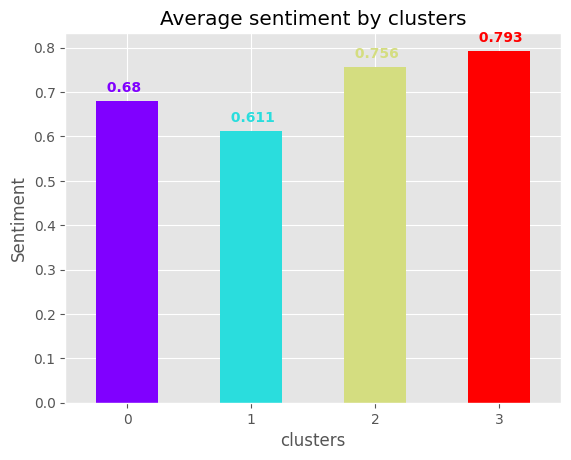

In [77]:
colors = plt.cm.rainbow(np.linspace(0, 1, 4))
iter_color = iter(colors)

df.groupby(['clusters'])["sentiment"].mean().plot.bar(rot=0, 
                                                      title="Average sentiment by clusters", 
                                                      ylabel="Sentiment",
                                                      color=plt.cm.rainbow(np.linspace(0, 1, 4)))

for i, v in enumerate(df.groupby(["clusters"])["sentiment"].mean()):
    c = next(iter_color)
    plt.text(i-0.2, v+0.03, " "+str(round(v,3)), color=c, va='center', fontweight='bold')

In [ ]:
'''
Thanks to topic modeling performed on customers reviews, we may find the most similar topic associated to the argument of interest and then, among that topic, recommend the most positively reviewed titles.

Therefore, we define a Recommendation class that takes the topic model and a search query as input, and provides methods to:

determine the most similar topic,
display its representation (class-based TF-IDF words scores) through a wordcloud chart, and
recommend the first n titles based on topic similarity and sentiment score:

In [104]:
topic, prob = topic_model.find_topics('piano', top_n=1)
topic, prob

([60], [0.6123996])

In [78]:
class Word:
    """Word class: an important concept and its score
        - w [string]: important word in a topic
        - s [double]: score of the word in the topic
    """

    def __init__(self, w, s):
        self.w = w
        self.s = s

    def __repr__(self):
        return '<word: "%s", score: %s>' % (self.w, self.s)

    def __str__(self):
        return '(word: "%s", score: %s)' % (self.w, self.s)
    
    # The __repr__ and __str__ methods are used to control how a Word object is displayed when you print it or convert it to a string. 
    # This can make your code easier to understand and debug
    # print(your_object) or str(your_object) will call your_object.__str__().
    # repr(your_object) or just typing your_object in a console will call your_object.__repr__().

In [105]:
topics_pivot.iloc[topic[0] + 1]

Topic                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [107]:
topic_model.get_topic(topic[0])

[('musica', 0.025893392931051716),
 ('musicale', 0.02287811777523759),
 ('musicali', 0.01614984911376329),
 ('pianoforte', 0.014761485765325185),
 ('jazz', 0.014353757277850526),
 ('dizzy', 0.010553625226555457),
 ('noti', 0.00964538095104087),
 ('stagioni', 0.009569171518567017),
 ('compositori', 0.00899762480369739),
 ('canzoni', 0.00883213853874612)]

In [108]:
[Word(iter[0], iter[1]) for iter in topic_model.get_topic(topic[0])]

[<word: "musica", score: 0.025893392931051716>,
 <word: "musicale", score: 0.02287811777523759>,
 <word: "musicali", score: 0.01614984911376329>,
 <word: "pianoforte", score: 0.014761485765325185>,
 <word: "jazz", score: 0.014353757277850526>,
 <word: "dizzy", score: 0.010553625226555457>,
 <word: "noti", score: 0.00964538095104087>,
 <word: "stagioni", score: 0.009569171518567017>,
 <word: "compositori", score: 0.00899762480369739>,
 <word: "canzoni", score: 0.00883213853874612>]

In [109]:
type([Word(iter[0], iter[1]) for iter in topic_model.get_topic(topic[0])][0])

__main__.Word

In [110]:
df["topics"].head()

0   -1
1   -1
2   -1
3   -1
4   -1
Name: topics, dtype: int64

In [111]:
topic_model.find_topics('piano', top_n=1)[0][0]

60

In [112]:
df["topics"]==topic_model.find_topics('piano', top_n=1)[0][0]

0        False
1        False
2        False
3        False
4        False
         ...  
18900    False
18901    False
18902    False
18903    False
18904    False
Name: topics, Length: 18905, dtype: bool

In [113]:
df.loc[df["topics"]==topic_model.find_topics('piano', top_n=1)[0][0]].head(1)

clusters Punteggio utente sul titolo Id. commento Punteggio medio titolo  \
322         0                        None         4100                   None   

    Cod. tipo materiale            Tipo documento Identificativo titolo  \
322                   M  Testo a stampa (moderno)                 24319   

     Eta' utente   Tipo utente Anno di pubblicazione    CAP Tipo materiale  \
322         56.0  NON OCCUPATO                  1975  00154  Libro moderno   

    Lingua 3 Lingua 2      Natura  \
322                    Monografia   

                                                                                             Descrizione commento  \
322  Per chi vuole approcciare alla musica, capire i tempi ed il ritmo, fare le prime letture. Consigliatissimo.    

     Lingua 1 Cod. tipo utente Cod. Lingua 1 Cod. natura Cod. Lingua 3  \
322  ITALIANO               NO           ITA           M                 

    Cod. Lingua 2 Cod. tipo documento  \
322                                LM   

                                                                                                                                                                                                                                         Titolo  \
322  *Come imparare a leggere la musica / Howard Shanet ; traduzione di Maria Luisa Canino ; apparato musicale integrato e adattato da Roberto Zanetti. - 2. ed. - Milano : Biblioteca universale Rizzoli, 1975. - 183 p. : ill., mus. ; 22 cm.   

           Titolo commento Data commento  topics  sentiment  
322  libro ben strutturato    2018/09/28      60     0.9997

In [114]:
len(df.loc[df["topics"]==topic_model.find_topics('piano', top_n=1)[0][0]])

27

In [115]:
df.loc[df["topics"]==topic_model.find_topics('piano', top_n=1)[0][0]].sort_values(by='sentiment', ascending=False)[["Titolo", "sentiment"]].head(3)

Titolo  \
8338                                                                                                                                                   *Ives, C.: Piano Sonatas Nos. 1-2 (Jensen). - Hong Kong : Naxos Digital Services Us Inc. - Registrazioni sonore musicali. ((Modalità di accesso: streaming   
663                                                                                                                                                                                                   *Castelli di rabbia / Alessandro Baricco. - Milano : Biblioteca universale Rizzoli, 1997. - 244 p. ; 20 cm.   
1700  La *ballata del vecchio marinaio / Samuel Taylor Coleridge ; traduzione Beppe Fenoglio ; illustrazioni: 21 disegni di Francesco Menzio ; note critiche: Andrea Cane, Paolo Fossati ; a cura di Filippo Fossati. - Torino : Stamperia del Borgo Po, \1988!. - 109 p. : ill. ; 30 cm. ((Testo orig. a fronte.   

      sentiment  
8338     0.9998  
663      0.9998  
1700     0.9998

In [116]:
# dict(self.words_score)
dict(topic_model.get_topic(topic_model.find_topics('piano', top_n=1)[0][0]))

{'musica': 0.025893392931051716,
 'musicale': 0.02287811777523759,
 'musicali': 0.01614984911376329,
 'pianoforte': 0.014761485765325185,
 'jazz': 0.014353757277850526,
 'dizzy': 0.010553625226555457,
 'noti': 0.00964538095104087,
 'stagioni': 0.009569171518567017,
 'compositori': 0.00899762480369739,
 'canzoni': 0.00883213853874612}

In [124]:
class Recommendation():
    """Recommendation class: 
        - inputs:
            - topic_model: BERTopic model
            - input concept (str): word from which to perform suggestions
        - vars:
            - t_id [int]: most similar topic id
            - sim [double]: similarity score
        - methods:
            - get_words: list of important words for the most similar topic
    """

    def __init__(self, input, topic_model):
        sim_topics, similarity = topic_model.find_topics(input, top_n=1)
        self.topic_id = sim_topics[0]
        self.similarity = similarity[0]
        self.words_score = topic_model.get_topic(self.topic_id)

    def __repr__(self):
        return '<topic_id: "%s", similarity: %s>' % (self.topic_id, self.similarity)

    def __str__(self):
        return '(topic_id: "%s", similarity: %s)' % (self.topic_id, self.similarity)

    def get_words(self):
        return [Word(iter[0], iter[1]) for iter in self.words_score]
    
    def get_titles(self, n):
        """get_titles: recommends books by users comment topic similarity and sentiment
        - inputs: 
            - n: number of books to recommend 
        - output:
            - df with ordered first n books (2 columns: Titolo, sentiment) 
        """
        return df.loc[df["topics"]==self.topic_id].sort_values(by='sentiment', ascending=False)[["Titolo", "sentiment"]].head(n)

    def get_wordcloud(self):
        """get_wordcloud: plots word cloud for the topic id
        Class-based TF-IDF scores are used instead of word frequencies (BERTopic)
        """
        wc = WordCloud().generate_from_frequencies(dict(self.words_score))
        plt.figure(figsize=(10, 8), dpi=80)
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.show()

In [125]:
topic_model # our bert model

In [145]:
r = Recommendation("c'è stato un assalto", topic_model)

print(r) # The __repr__ method is used when you call print(recommendation), which is why you see the topic ID and similarity score when you print the instance.

(topic_id: "3", similarity: 0.64357936)


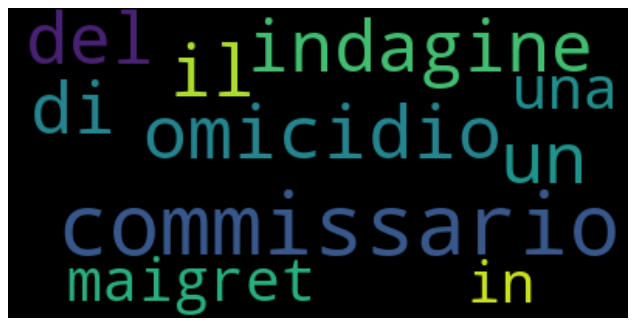

In [146]:
r.get_wordcloud()

In [147]:
# the top five topics, for better book title visualization
pd.set_option("display.max_colwidth", None)

r.get_titles(5)

Titolo  \
2303                                                                                           La *serie infernale / Agatha Christie ; traduzione di T.N.S. ; prefazione e postfazione di Renato Olivieri. - 19. rist. - Milano : Mondadori, 2003. - 205 p. ; 20 cm.   
4771                                                                                                                              *Ultime della notte / Petros Markaris ; traduzione di Grazia Loria. - 6. ed. - Milano : Tascabili Bompiani, 2008. - 343 p. ; 20 cm   
2484   Il *miglio verde / Stephen King. - 18. ed. - Milano : Sperling & Kupfer economica, stampa 2004. - XIX, 552, 19 p. ; 20 cm. ((Segue nota sull'autore e parte dell'introduzione del libro: La tempesta del secolo dello stesso autore. - Trad. di Tullio Dobner   
1983                                                                                                                                      *Ultime della notte / Petros Markaris ; traduzione di Grazia Loria. - [Milano] : Romanzo Bompiani, 2000. - 343 p. ; 21 cm.   
12242                                                                                                                                              *Ultime della notte / Petros Markaris. - [S.l.] : Bompiani, 2013. - 1 testo elettronico (EPUB) (368 p., 0.72 MB)    

       sentiment  
2303      0.9998  
4771      0.9998  
2484      0.9998  
1983      0.9998  
12242     0.9998

(topic_id: "56", similarity: 0.5636391)


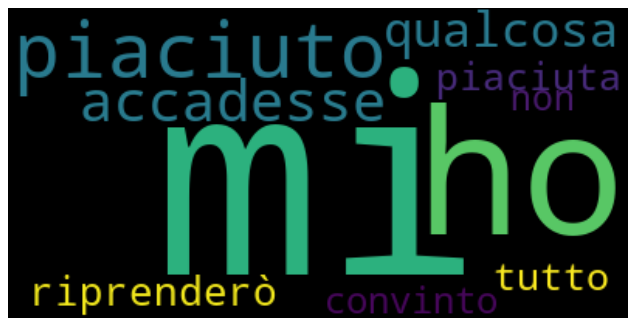

Titolo  \
17246  La *pianta del mondo / Stefano Mancuso ; con disegni dell'autore. - Bari ; Roma : Laterza, 2020. - 191 p. : ill. ; 23 cm   
13542                            *Sospeso / Giorgio Salati ; Armin Barducci. - Latina : Tunuè, 2018. - 153 p. : fumetti ; 25 cm   
13852                  *A 15 anni sei troppo vecchio / Markus Zusak. - [S.l.] : Frassinelli, 2017. - 1 testo elettronico (EPUB)   
12793         La *ragazza nella nebbia / romanzo di Donato Carrisi. - Milano : Longanesi, 2017. - 373 p. ; 24 cm. ((Ed. tie-in.   
10842  *Ninfee nere / Michel Bussi ; traduzione dal francese di Alberto Bracci Testasecca. - Roma : E/O, 2016. - 394 p. ; 21 cm   

       sentiment  
17246     0.9998  
13542     0.9998  
13852     0.9998  
12793     0.9997  
10842     0.9997

In [148]:
r = Recommendation("non ti lasceró piú", topic_model)
print(r)
# display most similar topic representation through a wordcloud chart
r.get_wordcloud()

# return the top 5 titles ordered by descending sentiment score
r.get_titles(5)

(topic_id: "60", similarity: 0.6123996)


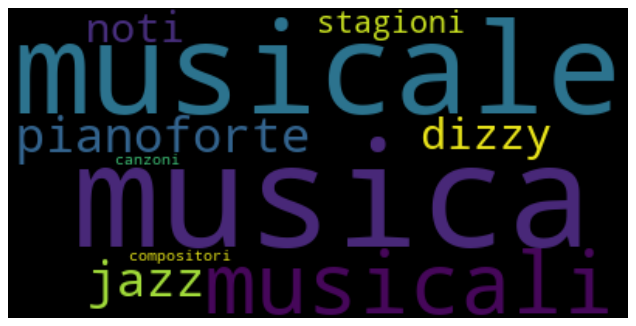

Titolo  \
8338                                                                                                                                                    *Ives, C.: Piano Sonatas Nos. 1-2 (Jensen). - Hong Kong : Naxos Digital Services Us Inc. - Registrazioni sonore musicali. ((Modalità di accesso: streaming   
663                                                                                                                                                                                                    *Castelli di rabbia / Alessandro Baricco. - Milano : Biblioteca universale Rizzoli, 1997. - 244 p. ; 20 cm.   
1700   La *ballata del vecchio marinaio / Samuel Taylor Coleridge ; traduzione Beppe Fenoglio ; illustrazioni: 21 disegni di Francesco Menzio ; note critiche: Andrea Cane, Paolo Fossati ; a cura di Filippo Fossati. - Torino : Stamperia del Borgo Po, \1988!. - 109 p. : ill. ; 30 cm. ((Testo orig. a fronte.   
3276                                                                                                                                                                                                                                 *Stagioni / Mario Rigoni Stern. - Torino : Einaudi, [2006]. - 145 p. ; 19 cm.   
12994                                                                                                                                             Il *romanzo della canzone italiana : storie, aneddoti e personaggi della canzone moderna (1958-2000) / Gino Castaldo. - Torino : Einaudi, 2018. - 376 p. ; 22 cm   

       sentiment  
8338      0.9998  
663       0.9998  
1700      0.9998  
3276      0.9998  
12994     0.9998

In [155]:
r = Recommendation("piano", topic_model)
print(r)
# display most similar topic representation through a wordcloud chart
r.get_wordcloud()

# return the top 5 titles ordered by descending sentiment score
r.get_titles(5)

(topic_id: "104", similarity: 0.57684773)


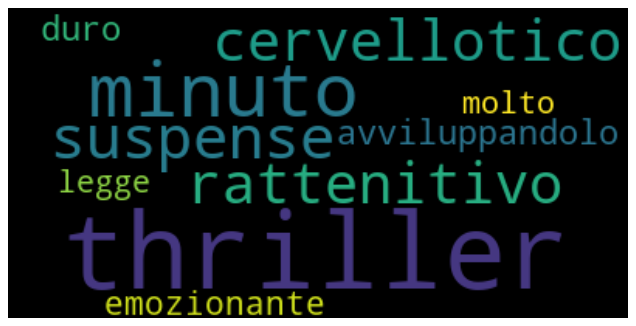

Titolo  \
1090                                                                                                                                                                                                                                                                                                                                                                                                                                  *Banda di fratelli / di Stephen E. Ambrose ; traduzione di Sergio Mancini. - Milano : Longanesi, \2000!. - 391 p., \4! c. di tav. : ill. ; 22 cm.   
13289                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              *Sara al tramonto / Maurizio De Giovanni. - Milano : Rizzoli, 2018. - 359 p. ; 22 cm   
15557  La *meccanica delle ombre / un film di Thomas Kruithof ; soggetto originale di Thomas Kruithof e Yann Gozlan ; direttore della fotografia Alex Lamarque ; musiche originali di Gregoire Auger. - RAI Cinema : 01 Distribution, 2017. - 1 DVD-Video (88 minuti circa) : color. ((Caratteristiche tecniche: codice area 2; PAL, 16/9, anamorfico, 2.35:1; Dolby Digital 5.1. - Riproduzione del film: Francia, Belgio 2016; interpreti:  François Cluzet, Denis Podalydes, Sami Bouajila, Alba Rohrwacher. -  Lingue: italiano, francese; sottotitoli: italiano. - Film per tutti.   
14262                                                                                                                                                                                                                                                                                                                                                                                                                                                           La *voce delle ombre / Frances Hardinge ; traduzione di Giuseppe Iacobaci. - Milano : Mondadori, 2018. - 429 p. ; 23 cm   
18131                                                                                                                                                                                                                                                                                                                                                                                                                                                             *Io e Mr Wilder / Jonathan Coe ; traduzione di Mariagiulia Castagnone. - Milano : Feltrinelli, 2021. - 234 p. ; 22 cm   

       sentiment  
1090      0.9998  
13289     0.9998  
15557     0.9998  
14262     0.9998  
18131     0.9998

In [156]:
r = Recommendation("horror", topic_model)
print(r)
# display most similar topic representation through a wordcloud chart
r.get_wordcloud()

# return the top 5 titles ordered by descending sentiment score
r.get_titles(5)

In [ ]:
'''
Recommendation by customers characteristics
In a scenario in which a user has no preferred topics or specific interests, and no search/loan history is available, recommendations may be still achieved by exploiting the customer segments produced by clustering.

Given a user’s age and occupation, we could find its cluster of belonging, and return the most positively reviewed titles in that cluster as recommendations:
'''

In [157]:
# clus_model.predict(33,'STUDENTE') 
obj_inp = pd.DataFrame({"Eta' utente": 33, "Tipo utente": 'STUDENTE'}, index=[0])
obj_inp

Eta' utente Tipo utente
0           33    STUDENTE

In [158]:
clus_model

KPrototypes(gamma=7.915638709395461, init='Huang', n_clusters=4,
            random_state=42)

In [159]:
clus_model.predict(obj_inp, categorical=[1]) 

array([2], dtype=uint16)

In [160]:
df.loc[df["clusters"]==2].sort_values(by='sentiment', ascending=False)[["Titolo", "sentiment"]].head(5) # using the cluster 2

Titolo  \
14694                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                *Oggi è il giorno giusto per dare una svolta alla tua vita : [romanzo] / Raphaëlle Giordano ; traduzione di Sara Arena. - Milano : Garzanti, 2019. - 358 p. ; 22 cm.   
6551   *Ex [Videoregistrazione] / regia Fausto Brizzi ; soggetto e sceneggiatura Fausto Brizzi, Marco Martani, Massimiliano Bruno ; musiche originali Bruno Zambrini. - 01 Distribution, [2009]. - 1 DVD (ca. 110 min.)  : color. ((Tit. del contenitore. - Caratteristiche tecniche: codice area 2; PAL, 2.35:1 panoramico, 16:9 anamorfico; Dolby digital 5.1 DTS. - DVD-9. - Ripr. del film: Italia, 2008; interpreti: Claudio Bisio, Nancy Brilli, Cristiana Capotondi, Cécile Cassel, Fabio De Luigi, Alessandro Gassman, Claudia Gerini, Flavio Insinna,  Silvio Orlando, Vincenzo Salemme, Gianmarco Tognazzi, Martina Pinto, Carla Signoris, Giorgia Wurth, Malik Zidi, Vincenzo Salemme, Elena Sofia Ricci. - Sottotitoli: italiano per non udenti; inglese. - Data di pubblicazione da repertori on-line. - Contenuti speciali: scene estese, scene eliminate, foto, trailer. - Film per tutti.   
6659                                                                                                                                                                                                                                                                             *Avatar [Videoregistrazione] / written and directed by James Cameron ; director of photography Mauro Fiore ; music by James Horner ; visual effects & animation by Weta Digital. - Twentieth Century Fox Home Entertainment, 2010. - 1 DVD (ca. 162 min.) : color. ((Tit. del contenitore. - Caratteristiche tecniche: codice area 2; PAL; 16:9 full frame version, 1.78 Aspect Ratio; Dolby digital 5.1. - Ripr. del film: Stati Uniti, Gran Bretagna, 2009; interpreti: Sam Worthington, Zoe Saldana, Stephen Lang, Michelle Rodriguez, Sigourney Weaver. - Lingue e sottotitoli: italiano, inglese. - Film per tutti.   
6653                                                                                                                                              Una *moglie bellissima / regia di Leonardo Pieraccioni ; soggetto e sceneggiatura Leonardo Pieraccioni, Giovanni Veronesi ; fotografia Italo Petriccione ; musiche Gianluca Sibaldi. - Medusa Video, 2007. - 1 DVD (93 min.) : color.  ((Tit. del contenitore. - Caratteristiche tecniche: codice area 2; PAL; panoramico, 2.35:1, ottimizzato per tv 16:9; Dolby digital 5.1. - Ripr. del film: Italia, 2007; interpreti: Leonardo Pieraccioni, Laura Torrisi, Gabriel Garko, Massimo Ceccherini, Rocco Papaleo, Francesco Guccini, Tony Sperandeo. - Lingue: italiano; sottotitoli: italiano per non udenti, inglese. - Contenuti speciali: interviste a Leonardo Pieraccioni, Laura Torrisi e cast,scene tagliate, papere, teaser. - Film per tutti.   
14358                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [161]:
class Reader:
    """Reader class:
        - inputs:
          - age [int]: age in years
          - job [double]: reader's profession
        - methods:
          - get_titles_from_reader: recommends books by top sentiment scores within reader cluster
    """

    def __init__(self, age, job):
        self.age = age
        self.job = job
        self.obj = pd.DataFrame({"Eta' utente": self.age, "Tipo utente": self.job}, index=[0])
        self.cluster = clus_model.predict(self.obj, categorical=[1])[0]

    def __repr__(self):
        return '<Reader: age: "%s", job: %s, cluster: %s>' % (self.age, self.job, self.cluster)

    def __str__(self):
        return '(Reader: age: "%s", job: %s, cluster: %s)' % (self.age, self.job, self.cluster)
    
    def get_titles_from_reader(self, n):
        """get_titles_from_reader: recommends books by top sentiment scores within reader cluster
          - inputs: 
            - n: number of books to recommend 
          - output:
            - df with ordered first n books (2 cols: Titolo, sentiment) 
        """
        return df.loc[df["clusters"]==self.cluster].sort_values(by='sentiment', ascending=False)[["Titolo", "sentiment"]].head(n)

In [162]:
new_reader = Reader(age= 62, job='CASALINGA')

new_reader

<Reader: age: "62", job: CASALINGA, cluster: 1>

In [163]:
new_reader.get_titles_from_reader(3)

Titolo  \
18903                              *Spizzichi e bocconi / Erri De Luca ; con interventi di Valerio Galasso. - Milano : Feltrinelli, 2022. - 190 p. : ill. ; 22 cm   
11477  Gli *assalti alle panetterie / Murakami Haruki ; illustrato da Igort ; traduzione di Antonietta Pastore. - Torino : Einaudi, 2016. - 57 p. : ill. ; 23 cm.   
4455                                Un *drink prima di uccidere / Dennis Lehane. - Casale Monferrato : Piemme, 2004. - 349 p. ; 22 cm. ((Trad. di Barbara Murgia.   

       sentiment  
18903     0.9998  
11477     0.9998  
4455      0.9998

In [164]:
new_reader = Reader(age= 12, job='STUDENTE')

new_reader.get_titles_from_reader(1)

Titolo  \
11  Il *gabbiano Jonathan Livingston / Richard Bach ; fotografie di Russel Munson ; traduzione di Pier Francesco Paolini. - Milano : Biblioteca universale Rizzoli, 1977. - 102 p. : ill. ; 18 cm.   

    sentiment  
11     0.9998

In [165]:
pd.reset_option('display.max_colwidth')
topics_comm = topics_pivot[topics_pivot.Topic!=-1][['Topic','Name']]
topics_comm['Name'] = topics_comm['Name'].str.replace(r'[0-9_]', ' ', regex=True)
topics_comm

Topic                                      Name
1        0                    film regista attori un
2        1                        libro ho mi questo
3        2             bambini libro bambino ragazzi
4        3                commissario omicidio il un
5        4                  donne femminile donna le
..     ...                                       ...
148    147      manzini editoria codignola scrittori
149    148           darwin marx evoluzione formiche
150    149               guerra soldati nemico paura
151    150         pirati mare affascinandolo voodoo
152    151                      seo web sito keyword

[152 rows x 2 columns]

In [166]:
df_comm = df[df.topics!=-1][['Descrizione commento','topics']]
df_comm.head()

Descrizione commento  topics
6   Lessi per la prima volta la trilogia della Fon...     113
7   Scritto in una prosa perfetta, "A sangue fredd...       3
11             Mi è piaciuto molto.\nLo consiglierei.      63
12                                        Bellissimo      112
13  Martin Eden è un libro potente, drammatico, br...      52

In [167]:
df_merged = df_comm.merge(topics_comm, left_on='topics', right_on='Topic').drop('topics', axis=1)
df_merged.head()

Descrizione commento  Topic  \
0  Lessi per la prima volta la trilogia della Fon...    113   
1  Scritto in una prosa perfetta, "A sangue fredd...      3   
2             Mi è piaciuto molto.\nLo consiglierei.     63   
3                                        Bellissimo     112   
4  Martin Eden è un libro potente, drammatico, br...     52   

                                     Name  
0      asimov robot fantascienza racconti  
1              commissario omicidio il un  
2                piaciuto mi molto perchã  
3           bello bellissimo succoso bllo  
4            connelly mcewan michael jack

In [168]:
df_merged.to_excel(r".commentstopics.xlsx")

In [170]:
# TfidfVectorizer is just one way to convert text data into numerical form. It’s often used because it gives more importance to words that are more meaningful (i.e., words that appear frequently in a document but not in all documents).

# In addition to vectorization, you might also need to consider dimensionality reduction techniques (like PCA or t-SNE) if your dataset is high-dimensional.

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(comments)
X

<18905x68326 sparse matrix of type '<class 'numpy.float64'>'
	with 1238129 stored elements in Compressed Sparse Row format>

In [173]:
cluster = AgglomerativeClustering(n_clusters=None, distance_threshold=0, affinity='euclidean', linkage='ward')
cluster

AgglomerativeClustering(affinity='euclidean', distance_threshold=0,
                        n_clusters=None)

In [ ]:
model = cluster.fit(X.toarray())
model